In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from utils import show_anns, create_color_list, visualize_sam, cuts_out,size_fileter,shape_filter,color_filter,register_shape_db,register_color_db

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# # Huge Model ~2.4 G
# sam_checkpoint = "/home/zippingsugar/Programs/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
# model_type = "vit_h"

# # Large Model ~ 1.2 G
# sam_checkpoint = "/home/zippingsugar/Programs/segment-anything/checkpoints/sam_vit_l_0b3195.pth"
# model_type = "vit_l"

# Big Model ~ 380 MB
sam_checkpoint = "/home/zippingsugar/Programs/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


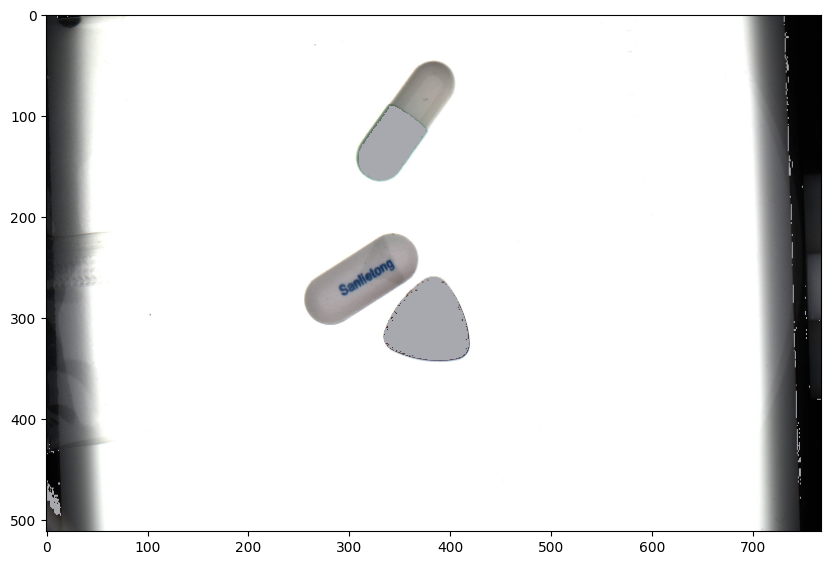

In [75]:
import os
img_dir = './'
img_name = "raw"
image = cv2.imread(os.path.join(img_dir,img_name+'.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (768, 512))
img = turn_green_into_white(image)
plt.figure(figsize=(10,10))
plt.imshow(img)
# plt.axis('off')
plt.show()

In [76]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side= 50,
    pred_iou_thresh=0.96,
    stability_score_thresh=0.97,
    min_mask_region_area=50,  # Requires open-cv to run post-processing
)

import time
st = time.time()
masks = mask_generator.generate(img)
et = time.time()
print(et-st)

4.690847158432007


In [78]:
from utils import visualize_sam, cuts_out,size_fileter,shape_filter,register_shape_db,pill_identify

shape_db = register_shape_db()
color_db = register_color_db()
masks = size_fileter(masks, min_area=5e2, max_area=2e4)
masks = shape_filter(masks, shape_db, threshold=0.07)
cuts_out(image, masks, save_dir='cuts_out')
masks = pill_identify(masks, cost=[0.20845539, 0.23003319, 0.23198423, 0.17678003, 0.15274716])

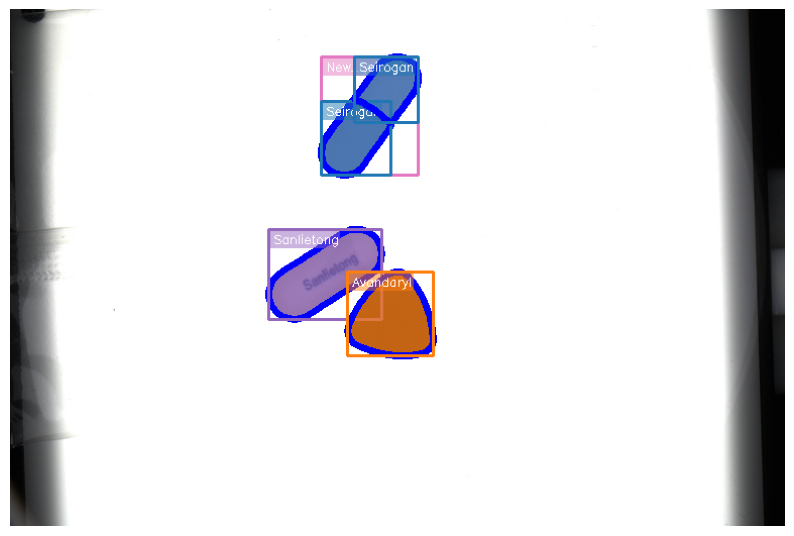

In [79]:
# color list for visualization
color_list = create_color_list(15)
plt.figure(figsize=(10,10)) 
img = image.copy() 
plt.imshow(img) 
# show_anns(masks)
visualize_sam(img,masks,color_list)
plt.axis('off') 
plt.show()

In [62]:
import cv2
import numpy as np

# Load the image and convert it to HSV color space
img = cv2.imread("database/pill_db/p6_0.jpg")

def turn_green_into_white(img):
    # plt.imshow(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # # Define the coordinate of the pixel (x, y)
    # x, y = 40,40

    # # Get the HSV value of the pixel
    # h, s, v = hsv[y, x]

    # # Print the HSV value
    # print(f"H: {h}, S: {s}, V: {v}")

    # Define the original and target colors (in HSV format)
    orig_color = (77, 92, 114) # greenish
    target_color = (0, 10, 175) # whiteish

    tolerance = 40

    # Create a mask that selects the pixels that have the original color
    lower = np.array(orig_color) - tolerance # lower bound of the original color
    upper = np.array(orig_color) + tolerance # upper bound of the original color
    lower[2] = 0 
    upper[2] = 255
    mask = cv2.inRange(hsv, lower, upper)

    # Change the color of the masked pixels to the target color
    hsv[mask > 0] = target_color

    # Convert the HSV image back to BGR and save it
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#     plt.imshow(img)
    
    return img

(77, 92)